In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
import tensorflow as tf
import os
from glob import glob


# Define the image size to resize to (256x256 for pix2pix)
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Helper function to load an image
def load_image(image_file, is_target=False):
    # Read the image file
    image = tf.io.read_file(image_file)
    
    # Decode the image as PNG (adjust if using other formats like JPEG)
    image = tf.image.decode_png(image, channels=3) if is_target else tf.image.decode_png(image, channels=1)
    
    # Cast the image to float32 for processing
    image = tf.cast(image, tf.float32)
    
    return image

# Resize both input (skeleton) and target images to the required size (256x256)
def resize(input_image, target_image, height, width):
    input_image = tf.image.resize(input_image, [height, width])
    target_image = tf.image.resize(target_image, [height, width])
    return input_image, target_image

# Normalize both images to the range [-1, 1]
def normalize(input_image, target_image):
    input_image = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1
    return input_image, target_image

# Preprocessing function to load and preprocess both skeleton and target images
def load_train_image(skeleton_path, target_path):
    input_image = load_image(skeleton_path, is_target=False)   # Grayscale (skeleton)
    target_image = load_image(target_path, is_target=True)     # RGB (target)

    # Resize both images to (256, 256)
    input_image, target_image = resize(input_image, target_image, IMG_HEIGHT, IMG_WIDTH)
    
    # Normalize the images to the range [-1, 1]
    input_image, target_image = normalize(input_image, target_image)
    
    return input_image, target_image

# Function to load dataset as TensorFlow Dataset object
def load_dataset(dataset_path, batch_size):
    skeleton_images = []
    target_images = []

    # Iterate over each train_X_img and train_X_label subfolder
    for i in range(1, 11):  # Assuming the folder names are train_1_img to train_10_label
        target_dir = os.path.join(dataset_path, f'train_{i}_img/')
        skeleton_dir = os.path.join(dataset_path, f'train_{i}_label/')
        
        # Collect all image file paths from both skeleton and target directories
        skeleton_images.extend(sorted(glob(os.path.join(skeleton_dir, '*.png'))))
        target_images.extend(sorted(glob(os.path.join(target_dir, '*.png'))))
    
    # Ensure that skeletons and targets have the same number of files
    assert len(skeleton_images) == len(target_images), "Mismatch in the number of skeleton and target images"

    # Create a TensorFlow Dataset from the file paths
    dataset = tf.data.Dataset.from_tensor_slices((skeleton_images, target_images))
    
    # Map the load_train_image function to each image pair
    dataset = dataset.map(lambda skeleton_path, target_path: tf.py_function(
        load_train_image, [skeleton_path, target_path], [tf.float32, tf.float32]))

    # Shuffle, batch, and prefetch the dataset for performance
    dataset = dataset.shuffle(buffer_size=400)  # Change this based on dataset size
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    print("dataset created")
    
    return dataset


In [3]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same', 
                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, 
                                      padding='same', 
                                      kernel_initializer=initializer, 
                                      use_bias=False))

    result.add(layers.BatchNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=[256, 256, 1])  # Assuming skeleton images are grayscale (1 channel)
    
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, 
                                  padding='same', 
                                  kernel_initializer=initializer, 
                                  activation='tanh')  # (bs, 256, 256, 3)
    
    x = inputs
    # Downsampling
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)


In [4]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    input_img = layers.Input(shape=[256, 256, 1], name='input_image')
    target_img = layers.Input(shape=[256, 256, 3], name='target_image')

    x = layers.concatenate([input_img, target_img])  # (bs, 256, 256, 4)
    
    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)
    
    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)
    
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)
    
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)
    
    return tf.keras.Model(inputs=[input_img, target_img], outputs=last)


In [5]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss


In [6]:

# Check if GPU is available and print the devices
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Enable dynamic memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU(s) available: {[gpu.name for gpu in gpus]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Running on CPU.")

1 GPU(s) available: ['/physical_device:GPU:0']


In [7]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(input_image, target, generator, discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    return gen_total_loss, disc_loss


In [8]:
def fit(generator, discriminator, dataset, epochs):
    cardinality = tf.data.experimental.cardinality(dataset)
    num_batches = cardinality.numpy()
    for epoch in range(epochs):
        start = time.time()
        batch = 1
        for input_image, target in dataset:
            print("Epoch no.: " + str(epoch) + " Batch no.: " + str(batch) + "/" + str(num_batches))
            gen_loss, disc_loss = train_step(input_image, target, generator, discriminator)
            batch+=1
        print(f"Epoch {epoch+1}/{epochs} | Generator Loss: {gen_loss} | Discriminator Loss: {disc_loss}")
        print(f'Time taken for epoch {epoch+1} is {time.time()-start} sec\n')


In [ ]:
BATCH_SIZE = 16  # Adjust based on your GPU memory

# Load dataset
DATASET_PATH = "/kaggle/input/frame-pose-dataset/video-pose dataset/data-meta"
train_dataset = load_dataset(DATASET_PATH, batch_size=BATCH_SIZE)

In [33]:
# Create generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Assume dataset is already loaded and preprocessed
fit(generator, discriminator, train_dataset, 10)

Epoch no.: 0 Batch no.: 1/1744
Epoch no.: 0 Batch no.: 2/1744
Epoch no.: 0 Batch no.: 3/1744
Epoch no.: 0 Batch no.: 4/1744
Epoch no.: 0 Batch no.: 5/1744
Epoch no.: 0 Batch no.: 6/1744
Epoch no.: 0 Batch no.: 7/1744
Epoch no.: 0 Batch no.: 8/1744
Epoch no.: 0 Batch no.: 9/1744
Epoch no.: 0 Batch no.: 10/1744
Epoch no.: 0 Batch no.: 11/1744
Epoch no.: 0 Batch no.: 12/1744
Epoch no.: 0 Batch no.: 13/1744
Epoch no.: 0 Batch no.: 14/1744
Epoch no.: 0 Batch no.: 15/1744
Epoch no.: 0 Batch no.: 16/1744
Epoch no.: 0 Batch no.: 17/1744
Epoch no.: 0 Batch no.: 18/1744
Epoch no.: 0 Batch no.: 19/1744
Epoch no.: 0 Batch no.: 20/1744
Epoch no.: 0 Batch no.: 21/1744
Epoch no.: 0 Batch no.: 22/1744
Epoch no.: 0 Batch no.: 23/1744
Epoch no.: 0 Batch no.: 24/1744
Epoch no.: 0 Batch no.: 25/1744
Epoch no.: 0 Batch no.: 26/1744
Epoch no.: 0 Batch no.: 27/1744
Epoch no.: 0 Batch no.: 28/1744
Epoch no.: 0 Batch no.: 29/1744
Epoch no.: 0 Batch no.: 30/1744
Epoch no.: 0 Batch no.: 31/1744
Epoch no.: 0 Batc

2024-10-22 16:34:56.759499: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_104_1/sequential_80_1/dropout_12_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1/10 | Generator Loss: 8.013368606567383 | Discriminator Loss: 1.2839137315750122
Time taken for epoch 1 is 2117.0971205234528 sec

Epoch no.: 1 Batch no.: 1/1744
Epoch no.: 1 Batch no.: 2/1744
Epoch no.: 1 Batch no.: 3/1744
Epoch no.: 1 Batch no.: 4/1744
Epoch no.: 1 Batch no.: 5/1744
Epoch no.: 1 Batch no.: 6/1744
Epoch no.: 1 Batch no.: 7/1744
Epoch no.: 1 Batch no.: 8/1744
Epoch no.: 1 Batch no.: 9/1744
Epoch no.: 1 Batch no.: 10/1744
Epoch no.: 1 Batch no.: 11/1744
Epoch no.: 1 Batch no.: 12/1744
Epoch no.: 1 Batch no.: 13/1744
Epoch no.: 1 Batch no.: 14/1744
Epoch no.: 1 Batch no.: 15/1744
Epoch no.: 1 Batch no.: 16/1744
Epoch no.: 1 Batch no.: 17/1744
Epoch no.: 1 Batch no.: 18/1744
Epoch no.: 1 Batch no.: 19/1744
Epoch no.: 1 Batch no.: 20/1744
Epoch no.: 1 Batch no.: 21/1744
Epoch no.: 1 Batch no.: 22/1744
Epoch no.: 1 Batch no.: 23/1744
Epoch no.: 1 Batch no.: 24/1744
Epoch no.: 1 Batch no.: 25/1744
Epoch no.: 1 Batch no.: 26/1744
Epoch no.: 1 Batch no.: 27/1744
Epoch n

KeyboardInterrupt: 

In [36]:
generator.save('/kaggle/working/generator-pretrained-pix2pix.h5')
discriminator.save('/kaggle/working/discriminator-pretrained-pix2pix.h5')

In [10]:
generator = tf.keras.models.load_model('/kaggle/working/generator-pretrained-pix2pix-10-epoch.h5')
discriminator = tf.keras.models.load_model('/kaggle/working/discriminator-pretrained-pix2pix-10-epoch.h5')

In [11]:
# Assume dataset is already loaded and preprocessed
fit(generator, discriminator, train_dataset, 10)

Epoch no.: 0 Batch no.: 1/1744


2024-10-31 09:45:26.624968: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_104_1/sequential_80_1/dropout_12_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch no.: 0 Batch no.: 2/1744
Epoch no.: 0 Batch no.: 3/1744
Epoch no.: 0 Batch no.: 4/1744
Epoch no.: 0 Batch no.: 5/1744
Epoch no.: 0 Batch no.: 6/1744
Epoch no.: 0 Batch no.: 7/1744
Epoch no.: 0 Batch no.: 8/1744
Epoch no.: 0 Batch no.: 9/1744
Epoch no.: 0 Batch no.: 10/1744
Epoch no.: 0 Batch no.: 11/1744
Epoch no.: 0 Batch no.: 12/1744
Epoch no.: 0 Batch no.: 13/1744
Epoch no.: 0 Batch no.: 14/1744
Epoch no.: 0 Batch no.: 15/1744
Epoch no.: 0 Batch no.: 16/1744
Epoch no.: 0 Batch no.: 17/1744
Epoch no.: 0 Batch no.: 18/1744
Epoch no.: 0 Batch no.: 19/1744
Epoch no.: 0 Batch no.: 20/1744
Epoch no.: 0 Batch no.: 21/1744
Epoch no.: 0 Batch no.: 22/1744
Epoch no.: 0 Batch no.: 23/1744
Epoch no.: 0 Batch no.: 24/1744
Epoch no.: 0 Batch no.: 25/1744
Epoch no.: 0 Batch no.: 26/1744
Epoch no.: 0 Batch no.: 27/1744
Epoch no.: 0 Batch no.: 28/1744
Epoch no.: 0 Batch no.: 29/1744
Epoch no.: 0 Batch no.: 30/1744
Epoch no.: 0 Batch no.: 31/1744
Epoch no.: 0 Batch no.: 32/1744
Epoch no.: 0 Bat

2024-10-31 10:20:56.932491: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_104_1/sequential_80_1/dropout_12_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1/10 | Generator Loss: 5.609081745147705 | Discriminator Loss: 0.8560094237327576
Time taken for epoch 1 is 2156.0949051380157 sec

Epoch no.: 1 Batch no.: 1/1744
Epoch no.: 1 Batch no.: 2/1744
Epoch no.: 1 Batch no.: 3/1744
Epoch no.: 1 Batch no.: 4/1744
Epoch no.: 1 Batch no.: 5/1744
Epoch no.: 1 Batch no.: 6/1744
Epoch no.: 1 Batch no.: 7/1744
Epoch no.: 1 Batch no.: 8/1744
Epoch no.: 1 Batch no.: 9/1744
Epoch no.: 1 Batch no.: 10/1744
Epoch no.: 1 Batch no.: 11/1744
Epoch no.: 1 Batch no.: 12/1744
Epoch no.: 1 Batch no.: 13/1744
Epoch no.: 1 Batch no.: 14/1744
Epoch no.: 1 Batch no.: 15/1744
Epoch no.: 1 Batch no.: 16/1744
Epoch no.: 1 Batch no.: 17/1744
Epoch no.: 1 Batch no.: 18/1744
Epoch no.: 1 Batch no.: 19/1744
Epoch no.: 1 Batch no.: 20/1744
Epoch no.: 1 Batch no.: 21/1744
Epoch no.: 1 Batch no.: 22/1744
Epoch no.: 1 Batch no.: 23/1744
Epoch no.: 1 Batch no.: 24/1744
Epoch no.: 1 Batch no.: 25/1744
Epoch no.: 1 Batch no.: 26/1744
Epoch no.: 1 Batch no.: 27/1744
Epoch n

In [1]:
generator.save('/kaggle/working/generator-pretrained-pix2pix-20-epoch.h5')
discriminator.save('/kaggle/working/discriminator-pretrained-pix2pix-20-epoch.h5')

NameError: name 'generator' is not defined

In [7]:
generator = tf.keras.models.load_model('/kaggle/working/generator-pretrained-pix2pix-10-epoch.h5')
discriminator = tf.keras.models.load_model('/kaggle/working/discriminator-pretrained-pix2pix-10-epoch.h5')

In [9]:
# Load the first pair of images in the dataset
i = 0
for skeleton, target in train_dataset:
    i+=1
    if i==5:
        skeleton = skeleton[15]
        target = target[15]
        break

In [10]:
import matplotlib.pyplot as plt

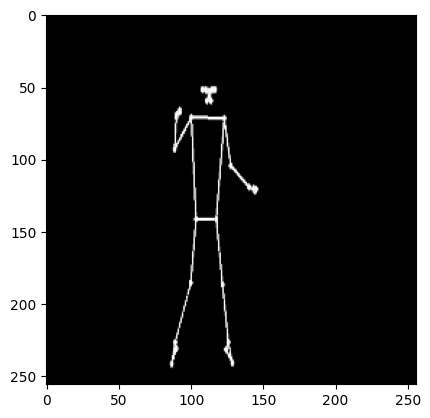

In [11]:
plt.imshow(skeleton, cmap='gray')

In [12]:
np.max(target)

0.9411764

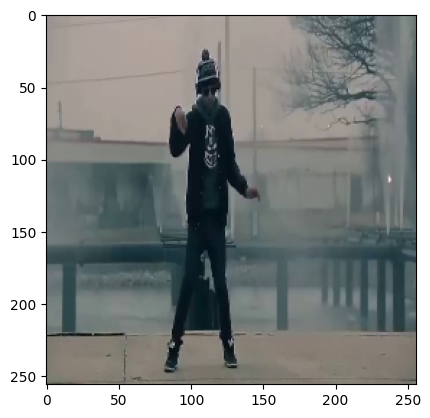

In [13]:
disp = 127.5*(target+1.)
plt.imshow(tf.cast(disp, tf.uint8))

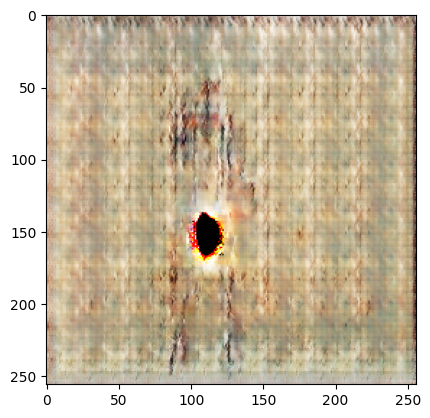

In [14]:
res = generator(tf.reshape(skeleton, (1,256,256,1)), training = False)
disp = 127.5*(res[0]+1)
plt.imshow(tf.cast(disp, tf.uint8))

# Code to perform metatraining

In [25]:
import tensorflow as tf

# Meta-learning parameters
meta_iterations = 100
meta_learning_rate = 1.0
batch_size = 8

def prepare_finetune_data(K_images, K_labels, batch_size=8):
    # Repeat images if K < 8
    if len(K_images) < batch_size:
        repeats = batch_size // len(K_images) + 1
        K_images = tf.concat([K_images] * repeats, axis=0)[:batch_size]
        K_labels = tf.concat([K_labels] * repeats, axis=0)[:batch_size]
    
    return tf.data.Dataset.from_tensor_slices((K_images, K_labels)).batch(batch_size)

def fine_tune_step(input_image, target_image, generator, discriminator, generator_optimizer, discriminator_optimizer):
    # Perform one fine-tuning step for the generator and discriminator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target_image], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_loss = generator_loss(disc_generated_output, gen_output, target_image)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

def fine_tune_model(K_images, K_labels, generator, discriminator, T, initial_lr=0.0002):
    # Prepare fine-tuning dataset
    fine_tune_data = prepare_finetune_data(K_images, K_labels, batch_size=batch_size)

    # Optimizers for fine-tuning
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
    
    # Fine-tuning loop
    for iteration in range(T):
        for input_image, target_image in fine_tune_data:
            gen_loss, disc_loss = fine_tune_step(input_image, target_image, generator, discriminator,
                                                 generator_optimizer, discriminator_optimizer)
            print('Gen_loss: ' + str(gen_loss[0].numpy()) + ' disc_loss: ' + str(disc_loss.numpy()))
        
        # Reduce learning rate after T/2 iterations
        if iteration >= T // 2:
            decay_rate = 1 - (iteration - T / 2) / (T / 2)
            generator_optimizer.learning_rate = initial_lr * decay_rate
            discriminator_optimizer.learning_rate = initial_lr * decay_rate

    return generator.get_weights(), discriminator.get_weights()

def meta_learning_step(K_images, K_labels, generator, discriminator, T, eps=1.0):
    # Store original weights
    original_generator_weights = generator.get_weights()
    original_discriminator_weights = discriminator.get_weights()

    # Fine-tune to get new weights
    new_generator_weights, new_discriminator_weights = fine_tune_model(K_images, K_labels, generator, discriminator, T)

    # Update original weights with meta-learning step
    updated_generator_weights = [(1 - eps) * orig + eps * new 
                                 for orig, new in zip(original_generator_weights, new_generator_weights)]
    updated_discriminator_weights = [(1 - eps) * orig + eps * new 
                                     for orig, new in zip(original_discriminator_weights, new_discriminator_weights)]

    # Set the updated weights back to the model
    generator.set_weights(updated_generator_weights)
    discriminator.set_weights(updated_discriminator_weights)
    
    return generator, discriminator

def meta_train(K_images, K_labels, generator, discriminator, T):
    for meta_iter in range(meta_iterations):
        # Linearly decay epsilon over meta iterations
        eps = meta_learning_rate * (1 - meta_iter / meta_iterations)
        
        print(f"Meta-Iteration {meta_iter + 1}/{meta_iterations}, Epsilon: {eps:.4f}")
        
        # Perform a meta-learning step
        generator, discriminator = meta_learning_step(K_images, K_labels, generator, discriminator, T, eps)
        
        # Optionally, print progress or intermediate metrics
#         if (meta_iter + 1) % 50 == 0:
#             print(f"Completed Meta-Iteration {meta_iter + 1}, Meta Learning Rate (Eps): {eps:.4f}")
    
    return generator, discriminator

First, we'll attempt meta training on the original training dataset images. Use K = 5 here.

In [17]:
BATCH_SIZE = 16
DATASET_PATH = "/kaggle/input/meta-train-video-pose-dataset/meta-video-pose dataset/data-meta"
meta_test_dataset = load_dataset(DATASET_PATH, batch_size=BATCH_SIZE)

dataset created


In [18]:
# Load 1 batch and get K samples for meta training. Use the rest for meta testing
K = 5
for skeleton, target in meta_test_dataset:
    meta_train_skeleton = skeleton[:K]
    meta_train_target = target[:K]
    meta_test_skeleton = skeleton[K:]
    meta_test_target = target[K:]
    break

In [26]:
T = 20  # No. of fine tuning iterations
generator = tf.keras.models.load_model('/kaggle/working/generator-pretrained-pix2pix-10-epoch.h5')
discriminator = tf.keras.models.load_model('/kaggle/working/discriminator-pretrained-pix2pix-10-epoch.h5')
generator, discriminator = meta_train(meta_train_skeleton, meta_train_target, generator, discriminator, T)

Meta-Iteration 1/100, Epsilon: 1.0000
Gen_loss: 66.80019 disc_loss: 1.8372496
Gen_loss: 63.61631 disc_loss: 0.7787196
Gen_loss: 56.69207 disc_loss: 0.50015473
Gen_loss: 51.560562 disc_loss: 0.35275894
Gen_loss: 47.626503 disc_loss: 0.42486745
Gen_loss: 44.752613 disc_loss: 0.35874546
Gen_loss: 42.7867 disc_loss: 0.2970754
Gen_loss: 41.120457 disc_loss: 0.33793223
Gen_loss: 39.555252 disc_loss: 0.31914827
Gen_loss: 38.090324 disc_loss: 0.36538583
Gen_loss: 35.93301 disc_loss: 0.38438165
Gen_loss: 34.74332 disc_loss: 0.45767188
Gen_loss: 34.18389 disc_loss: 0.41836482
Gen_loss: 34.324757 disc_loss: 0.42141983
Gen_loss: 33.97111 disc_loss: 0.48158208
Gen_loss: 33.51404 disc_loss: 0.42190322
Gen_loss: 33.064274 disc_loss: 0.39921075
Gen_loss: 32.697826 disc_loss: 0.47848743
Gen_loss: 32.353672 disc_loss: 0.4496132
Gen_loss: 32.21888 disc_loss: 0.45894152
Meta-Iteration 2/100, Epsilon: 0.9900
Gen_loss: 32.18107 disc_loss: 0.44071537
Gen_loss: 32.911125 disc_loss: 0.92362905
Gen_loss: 30.257

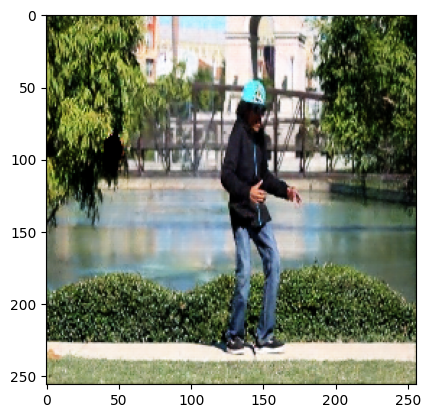

In [27]:
skeleton = meta_train_skeleton[0]
res = generator(tf.reshape(skeleton, (1,256,256,1)), training = False)
disp = 127.5*(res[0]+1)
plt.imshow(tf.cast(disp, tf.uint8))

# Calculating PSNR, SSIM & MSE to evaluate meta trained model

In [28]:
# generator = tf.keras.models.load_model('/kaggle/working/personalized-generator-pretrained-pix2pix.h5')
# discriminator = tf.keras.models.load_model('/kaggle/working/personalized-discriminator-pretrained-pix2pix.h5')

psnr_vals = []
ssim_vals = []
mse_vals = []

for i in range(1,3001):
    # Load target image and skeleton
    skeleton_path = '/kaggle/input/meta-train-video-pose-dataset/meta-video-pose dataset/data-meta/train_1_label/label_'+ str(i) + '.png'
    target_path = '/kaggle/input/meta-train-video-pose-dataset/meta-video-pose dataset/data-meta/train_1_img/img_'+ str(i) + '.png'
    skeleton, target = load_train_image(skeleton_path, target_path) 
    
    # Generate output and renormalize to 0-255 range
    res = generator(tf.reshape(skeleton, (1,256,256,1)), training = False)
    res = tf.cast(127.5*(res[0]+1), tf.uint8)
    target = tf.cast(127.5*(target+1), tf.uint8) # renormalize
    
    # Compute metrics
    mse = tf.reduce_mean(tf.square(res - target))
    psnr = tf.image.psnr(res, target, max_val=255)
    ssim = tf.image.ssim(res, target, max_val=255)
    psnr_vals.append(psnr)
    ssim_vals.append(ssim)
    mse_vals.append(mse)

In [29]:
import numpy as np
print('Mean MSE: ', np.mean(mse_vals))
print('Mean PSNR: ', np.mean(psnr_vals))
print('Mean SSIM: ', np.mean(ssim_vals))

Mean MSE:  85.448
Mean PSNR:  15.913048
Mean SSIM:  0.4877749


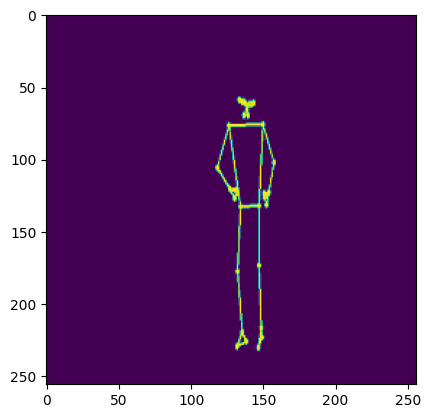

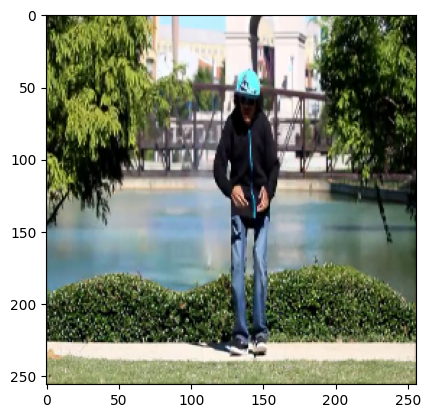

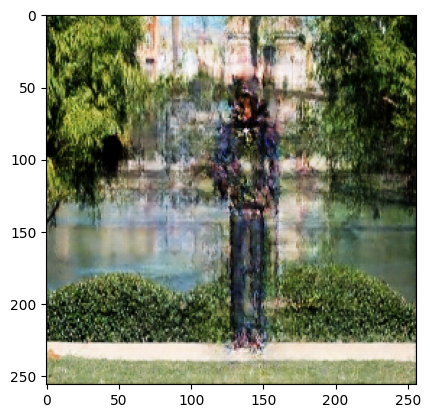

In [30]:
plt.imshow(skeleton)
plt.show()
plt.imshow(target)
plt.show()
plt.imshow(res)

In [22]:
# Load a different image for testing
# Load 1 batch and get K samples for meta training. Use the rest for meta testing
i = 0
for skeleton, target in train_dataset:
    i+=1
    if i==5:
        meta_test_skeleton = skeleton[K:]
        meta_test_target = target[K:]
        break

In [30]:
skeleton, target = load_train_image('/kaggle/input/frame-pose-dataset/video-pose dataset/data-meta/train_2_label/label_100.png', 
                                    '/kaggle/input/frame-pose-dataset/video-pose dataset/data-meta/train_2_img/img_100.png')

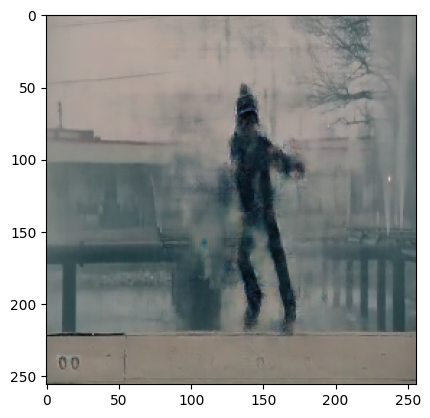

In [32]:
# skeleton = meta_test_skeleton[10]
res = generator(tf.reshape(skeleton, (1,256,256,1)), training = False)
disp = 127.5*(res[0]+1)
plt.imshow(tf.cast(disp, tf.uint8))

In [43]:
os.mkdir('meta-test-results-1')

In [44]:
import cv2

skeleton_folder = '/kaggle/input/frame-pose-dataset/video-pose dataset/data-meta/train_2_label'
i=1
for num in range(1,501):
    skeleton_path = os.path.join(skeleton_folder, 'label_'+str(num)+'.png')
    skeleton, target = load_train_image(skeleton_path, 
                                    '/kaggle/input/frame-pose-dataset/video-pose dataset/data-meta/train_2_img/img_100.png')
    res = generator(tf.reshape(skeleton, (1,256,256,1)), training = False)
    disp = tf.cast(127.5*(res[0]+1), tf.uint8)
    disp = disp.numpy()
    cv2.imwrite('meta-test-results-1/img' + str(i) + '.png', disp)
    i+=1
    

In [45]:
frames = []
for i in range(1,501):
    img = cv2.imread('meta-test-results-1/img' + str(i) + '.png')
    frames.append(img)

In [51]:
import cv2
import numpy as np
 
def create_video_from_frames(frames, output_path="output_video.mp4", fps=30):
    """
    Creates a video from a list of frames.
    
    Args:
        frames (list of np.array): List of frames, each as a numpy array (e.g., output from Pix2Pix model).
        output_path (str): Path to save the output video.
        fps (int): Frames per second for the output video.
        
    Returns:
        None
    """
    # Check if frames list is empty
    if not frames:
        raise ValueError("The list of frames is empty.")
 
    # Get the frame dimensions from the first frame
    height, width, layers = frames[0].shape
    
    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4 video
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
 
    # Write each frame to the video
    for frame in frames:
        # Ensure the frame is in the right format
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR if necessary
        video_writer.write(frame)
 
    # Release the video writer
    video_writer.release()
    print(f"Video saved at {output_path}")
 
# Assuming frames_list is a list of frames from the Pix2Pix model (each as a numpy array)
create_video_from_frames(frames, output_path="pix2pix_output_video-2.mp4", fps=30)

Video saved at pix2pix_output_video-2.mp4


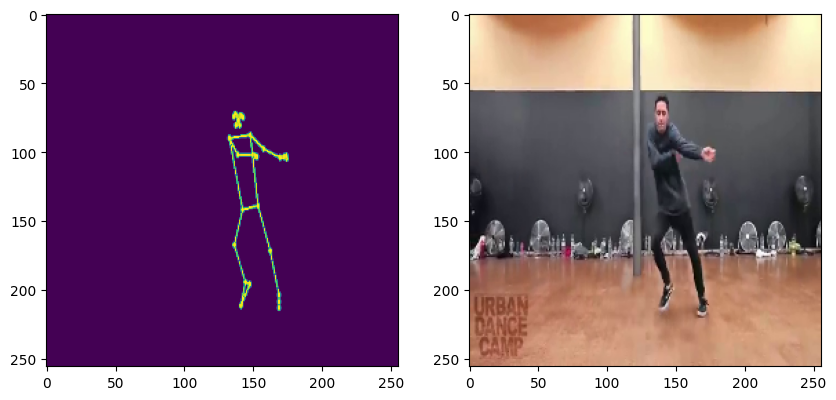

In [31]:
fig = plt.figure(figsize=(10, 7)) 
# Plot skeleton
fig.add_subplot(1, 2, 1)
plt.imshow(skeleton)
        
# Plot target
fig.add_subplot(1,2,2)
tgt = 127.5*(target+1)
plt.imshow(tf.cast(tgt, tf.uint8))

# Meta-training & testing on unseen dataset

In [23]:
import os

# Load and display 5 images from the unseen video
target_path = "/kaggle/input/meta-train-video-pose-dataset/meta-video-pose dataset/data-meta/train_1_img"
skeleton_path = "/kaggle/input/meta-train-video-pose-dataset/meta-video-pose dataset/data-meta/train_1_label"

target_files = ['img_200.png','img_251.png','img_302.png','img_403.png','img_504.png']
skeleton_files = ['label_200.png','label_251.png','label_302.png','label_403.png','label_504.png']

skeletons = []
targets = []

for i in range(len(target_files)):
    target = os.path.join(target_path,target_files[i])
    skeleton = os.path.join(skeleton_path, skeleton_files[i])
    skeleton, target = load_train_image(skeleton, target)
    skeletons.append(skeleton)
    targets.append(target)

skeletons = tf.stack(skeletons)
targets = tf.stack(targets)

In [ ]:
# Meta training
T = 20  # No. of fine tuning iterations
generator = tf.keras.models.load_model('/kaggle/working/generator-pretrained-pix2pix-10-epoch.h5')
discriminator = tf.keras.models.load_model('/kaggle/working/discriminator-pretrained-pix2pix-10-epoch.h5')
generator, discriminator = meta_train(skeletons, targets, generator, discriminator, T)

Meta-Iteration 1/300, Epsilon: 1.0000
Meta-Iteration 2/300, Epsilon: 0.9967
Meta-Iteration 3/300, Epsilon: 0.9933
Meta-Iteration 4/300, Epsilon: 0.9900
Meta-Iteration 5/300, Epsilon: 0.9867
Meta-Iteration 6/300, Epsilon: 0.9833
Meta-Iteration 7/300, Epsilon: 0.9800
Meta-Iteration 8/300, Epsilon: 0.9767
Meta-Iteration 9/300, Epsilon: 0.9733
Meta-Iteration 10/300, Epsilon: 0.9700
Meta-Iteration 11/300, Epsilon: 0.9667
Meta-Iteration 12/300, Epsilon: 0.9633
Meta-Iteration 13/300, Epsilon: 0.9600
Meta-Iteration 14/300, Epsilon: 0.9567
Meta-Iteration 15/300, Epsilon: 0.9533
Meta-Iteration 16/300, Epsilon: 0.9500
Meta-Iteration 17/300, Epsilon: 0.9467
Meta-Iteration 18/300, Epsilon: 0.9433
Meta-Iteration 19/300, Epsilon: 0.9400
Meta-Iteration 20/300, Epsilon: 0.9367
Meta-Iteration 21/300, Epsilon: 0.9333
Meta-Iteration 22/300, Epsilon: 0.9300
Meta-Iteration 23/300, Epsilon: 0.9267
Meta-Iteration 24/300, Epsilon: 0.9233
Meta-Iteration 25/300, Epsilon: 0.9200
Meta-Iteration 26/300, Epsilon: 0.

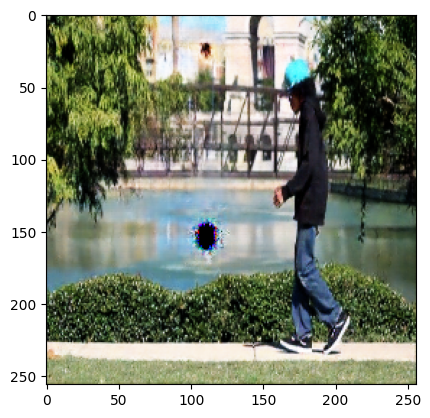

In [15]:
# Visualize performance on meta-training data
skeleton = skeletons[0]
res = generator(tf.reshape(skeleton, (1,256,256,1)), training = False)
disp = 127.5*(res[0]+1)
plt.imshow(tf.cast(disp, tf.uint8))

In [16]:
# Load and display 10 images from the unseen video
target_path = "/kaggle/input/meta-train-video-pose-dataset/meta-video-pose dataset/data-meta/train_1_img"
skeleton_path = "/kaggle/input/meta-train-video-pose-dataset/meta-video-pose dataset/data-meta/train_1_label"

target_files = ['img_600.png','img_630.png','img_650.png','img_670.png','img_700.png']
skeleton_files = ['label_600.png','label_630.png','label_650.png','label_670.png','label_700.png']

skeletons = []
targets = []

for i in range(len(target_files)):
    target = os.path.join(target_path,target_files[i])
    skeleton = os.path.join(skeleton_path, skeleton_files[i])
    skeleton, target = load_train_image(skeleton, target)
    skeletons.append(skeleton)
    targets.append(target)

skeletons = tf.stack(skeletons)
targets = tf.stack(targets)

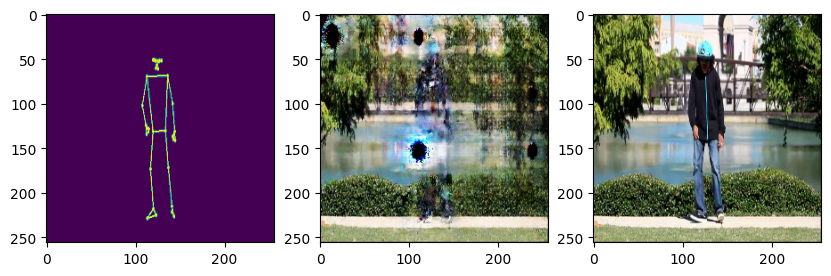

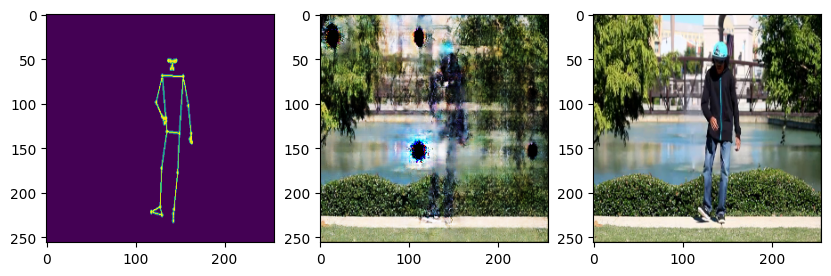

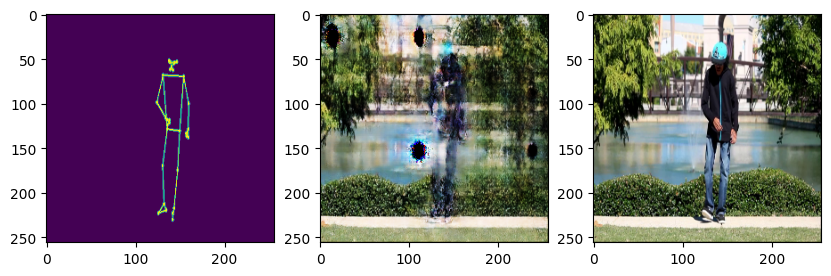

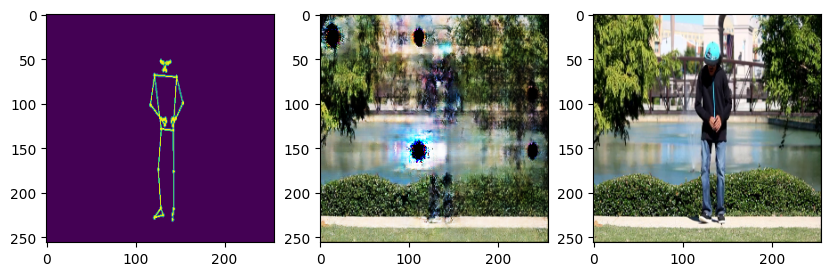

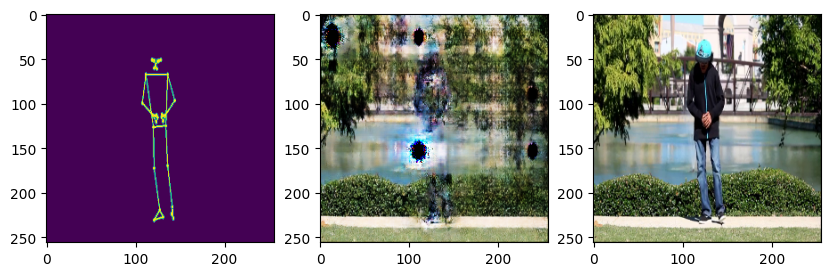

In [21]:
results = generator(skeletons, training = False)

for i in range(5):
    fig = plt.figure(figsize=(10, 7)) 
    # Plot skeleton
    fig.add_subplot(1, 3, 1)
    plt.imshow(skeletons[i])
    
    # Plot result
    fig.add_subplot(1,3,2)
    res = 127.5*(results[i]+1)
    plt.imshow(tf.cast(res, tf.uint8))
    
    # Plot target
    fig.add_subplot(1,3,3)
    tgt = 127.5*(targets[i]+1)
    plt.imshow(tf.cast(tgt, tf.uint8))

In [59]:
# Step 1: Install Streamlit and ngrok
!pip install streamlit -q
!pip install pyngrok -q

# Step 2: Write Streamlit code to a .py file
with open("app1.py", "w") as f:
    f.write("""
import streamlit as st
import mediapipe as mp

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Setup Pose Estimation with MediaPipe
pose = mp_pose.Pose()

def skeletonize(img):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    height, width, _ = img.shape
    black_image = np.zeros((height, width, 3), dtype=np.uint8)

    if results.pose_landmarks:
    # Draw pose landmarks and skeleton on the black image
        mp_drawing.draw_landmarks(
            black_image, 
            results.pose_landmarks, 
            mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=1),  # White dots for landmarks
            mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=2)   # White lines for connections
        )
    
    return black_image

def main():
    st.title("Video Retargetting using few shot learning")

    # Section for uploading a video
    st.header("Upload Video")
    uploaded_video = st.file_uploader("Choose a video file", type=["mp4", "mov", "avi", "mkv"])

    # Section for uploading the first image
    st.header("Upload First Image")
    uploaded_image1 = st.file_uploader("Choose the first image file", type=["jpg", "jpeg", "png"], key="image1")

    # Button to process the uploaded files
    if st.button("Submit"):
        if uploaded_video and uploaded_image1:
            # Mock backend processing
            generator = tf.keras.models.load_model('/kaggle/working/generator-pretrained-pix2pix-10-epoch.h5')
            discriminator = tf.keras.models.load_model('/kaggle/working/discriminator-pretrained-pix2pix-10-epoch.h5')
            skeletons = []
            skeletons.append(skeletonize(uploaded_image1))
            generator, discriminator = meta_train(skeletons, targets, generator, discriminator, T)
            
            
            st.success("Files successfully uploaded and processed!")
            output_video_path = "path_to_processed_video.mp4" # Replace with actual path after processing
 
            # Display the output video
            st.header("Processed Output Video")
            st.video(output_video_path)
 
            # Display output metrics
            st.header("Output Metrics")
            st.metric("Metric 1", "85%")
            st.metric("Metric 2", "0.75")
            st.metric("Metric 3", "5.6")
            # You can add more metrics here
 
        else:
            st.error("Please upload all files (video and two images) to proceed.")

if __name__ == "__main__":
    main()
""")

# Step 3: Start ngrok tunnel
from pyngrok import ngrok
import subprocess

# Replace with your actual ngrok token
ngrok.set_auth_token("2oFR7zeIzpGtnJ422nlKAS6CCZn_5EyAhpGXbAE6xDPqoSXhL") # Replace with your actual token

# Start the ngrok tunnel
public_url = ngrok.connect(8501) # Connect to the default Streamlit port 8501
print("Streamlit URL:", public_url)

# Step 4: Run Streamlit app
subprocess.Popen(["streamlit","run","app1.py"])

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Streamlit URL: NgrokTunnel: "https://3cb8-34-42-38-231.ngrok-free.app" -> "http://localhost:8501"


<Popen: returncode: None args: ['streamlit', 'run', 'app1.py']>




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://172.19.2.2:8502
  External URL: http://34.42.38.231:8502



In [3]:
!kaggle download -d '/kaggle/working/generator-pretrained-pix2pix-10-epoch.h5' -p /content --unzip

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


<a href="/kaggle/working/generator-pretrained-pix2pix-10-epoch.h5"> Download generator </a>